In [1]:
# Imports
import sys

sys.path.insert(0, "../..")

from qiskit import QuantumCircuit, qasm2
from qiskit.quantum_info import Clifford, StabilizerState,state_fidelity
from qiskit.visualization import array_to_latex
from qiskit_aer import AerSimulator
import random
from visualisation import LiveVisualizer,GraphWatcher,MatrixWatcher
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Clifford
from qiskit_aer import AerSimulator

from classical_shadow_n_clifford import ClassicalShadow_N_CLIFFORD
from shadow_protocol import ShadowProtocol

In [2]:
# Setup Experiment
class Id_Protocol(ShadowProtocol):

    def get_num_qubits(self) -> int:
        return 2
    
    def get_state_circuit(self) -> QuantumCircuit:
        circuit = QuantumCircuit(2)
        circuit.x(0)
        return circuit

    def run_circuit_and_get_measurement(self, circuit) -> list[int]:
        sim = AerSimulator()

        # Run with 997 shots
        job = sim.run(circuit, shots=997)
        result = job.result()

        counts = result.get_counts()
        max_hits= max(counts, key=counts.get)
        bit_list =  [int(bit) for bit in list(max_hits)]
        return bit_list[::-1] 
    
id_protocol = Id_Protocol()
# Create Classical Shadow Instance
shadow = ClassicalShadow_N_CLIFFORD(id_protocol)


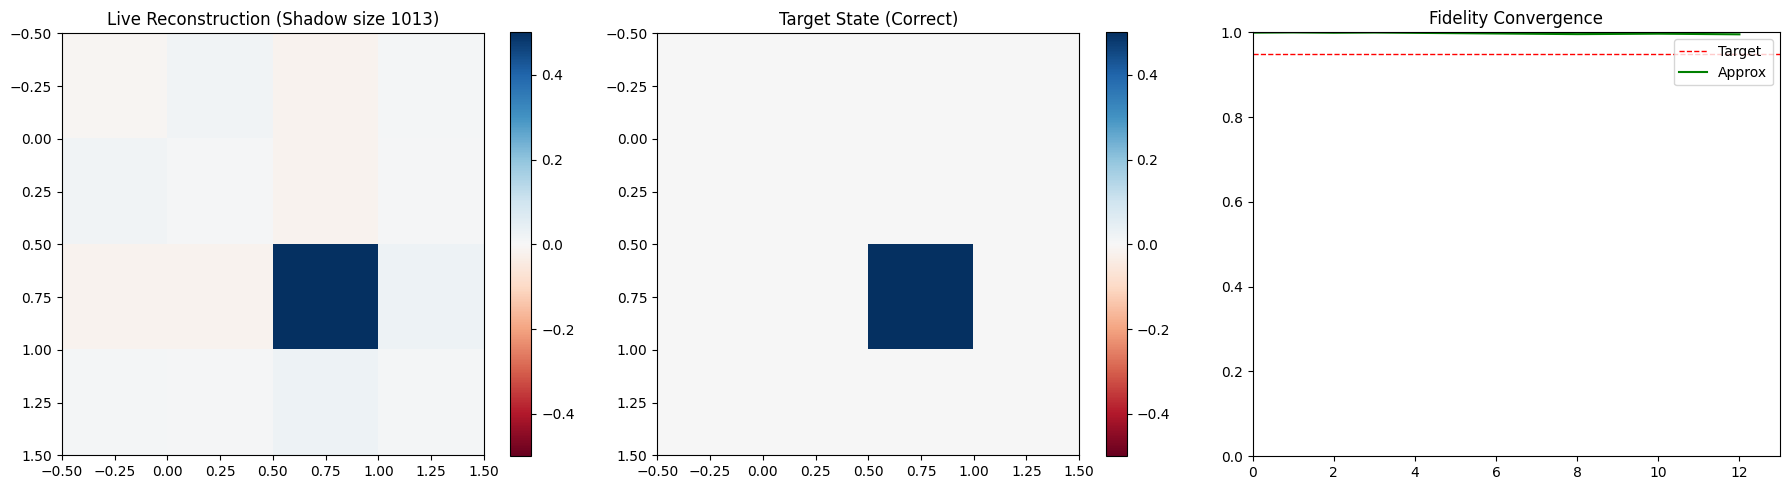

KeyboardInterrupt: 

In [ ]:
live_matrix_view = MatrixWatcher(
    title_template="Live Reconstruction (Shadow size {})"
)

target_matrix_view = MatrixWatcher(
    title_template="Target State (Correct)"
)

fidelity_graph = GraphWatcher(
    title="Fidelity Convergence", 
    target_value=0.95, 
    y_min=0.0, 
    y_max=1.0
)

vis = LiveVisualizer(live_matrix_view, target_matrix_view, fidelity_graph)

target_density_matrix = shadow.get_original_density_matrix()

# List to store history for the graph
fidelity_history = []

while True:
    shadow.add_snapshot()
    
    shadow_size = shadow.get_shadow_size()
        
    # Get Data
    actual_matrix = shadow.get_density_matrix_from_cliffords()
    
    # Calculate some number for the graph (example: fidelity or trace)
    current_val = shadow.ge
    fidelity_history.append(current_val)
    # UPDATE: Pass shadow_size first, then data for Matrix 1, Matrix 2, Graph 1
    vis.update(
        shadow_size,           # The 'iteration'
        actual_matrix,         # Data for live_matrix_view
        target_density_matrix, # Data for target_matrix_view
        fidelity_history       # Data for fidelity_graph
    )

### Efficient Fidelity Estimation with Classical Shadows

When generating a classical shadow, we do not store the full snapshot matrix:
$$\hat{\rho} = \mathcal{M}^{-1}(U^\dagger |\hat{b}\rangle \langle \hat{b}| U)$$

Instead, we only store the efficient stabilizer representation of the state $|\phi\rangle = U^\dagger |\hat{b}\rangle$ according to the Gottesman-Knill theorem.

Explicitly applying $\mathcal{M}^{-1}$ would result in a matrix that is no longer a stabilizer state (due to the subtraction of the identity matrix), making it inefficient to store.

However, to calculate the fidelity with a target state $|\psi\rangle$, we can use the linearity of the trace to avoid constructing the full matrix. We estimate:

$$\text{tr}(|\psi\rangle \langle\psi| \hat{\rho})$$

Using the inverse channel formula $\mathcal{M}^{-1}(X) = (2^n + 1)X - \mathbb{I}$, we can rewrite the equation as:

$$
\begin{aligned}
\text{Est. Fidelity} &= \text{tr}\left( |\psi\rangle \langle\psi| \left[ (2^n + 1) |\phi\rangle \langle\phi| - \mathbb{I} \right] \right) \\
&= (2^n + 1) \text{tr}\left( |\psi\rangle \langle\psi| \phi\rangle \langle\phi| \right) - \text{tr}\left( |\psi\rangle \langle\psi| \mathbb{I} \right) \\
&= (2^n + 1) |\langle \psi | \phi \rangle|^2 - 1
\end{aligned}
$$

Calculating the overlap $|\langle \psi | \phi \rangle|^2$ between two pure states is computationally much more efficient than processing the full density matrix.

In [ ]:
# Ort sate so the out come should be 0

ortognal_cir = QuantumCircuit(2)
ortognal_clifford = Clifford(ortognal_cir)

In [ ]:
# Same sate so the out come should be 1

same_cir = QuantumCircuit(2)
same_cir.x(0)
same_clifford = Clifford(same_cir)

In [ ]:
def getFidelity(clifford_a: Clifford) -> float:
    n_qubits = clifford_a.num_qubits

    # change qbit order of input clifford
    qc_reverse = QuantumCircuit(n_qubits)
    for i in range(n_qubits // 2):
        qc_reverse.swap(i, n_qubits - 1 - i)
    clifford_reverse = Clifford(qc_reverse)

    clifford_a = clifford_a.compose(clifford_reverse)

    clifford_list_list = shadow.clifford_list_list
    overlaps: list[float] = [] 
    
 
    cliff_a_inv = clifford_a.adjoint()

    for cliff_list in clifford_list_list:
        assert len(cliff_list) == 1
        cliff_b: Clifford = cliff_list[0]

        # |<a|b>|^2
        combined_cliff = cliff_b.compose(cliff_a_inv)
        zero_state = StabilizerState(combined_cliff)
        
        probs = zero_state.probabilities_dict()
        overlap = probs.get("0" * n_qubits, 0.0)
        
        overlaps.append(overlap)

    if not overlaps:
        raise ValueError("Shadow list is empty.")


    mean_overlap = sum(overlaps) / len(overlaps)

    fidelity = (2**n_qubits + 1) * mean_overlap - 1

    return fidelity

In [ ]:
print(getFidelity(same_clifford))
print(getFidelity(ortognal_clifford))

1.0148514851485149
0.0
